# Tutorial: GNN Implementation (PyTorch Geometric)

Welcome to this tutorial on Graph Neural Networks (GNNs). We begin by building a GCN (Kipf & Welling, 2017) from scratch for node classification on the Karate Club dataset to illustrate the core operations. Next, we'll perform graph classification on the MUTAG dataset—a well-known chemical compound benchmark. Finally, we'll leverage PyTorch Geometric’s built-in modules—including additional GNN layers and pooling methods—to construct more advanced models, while also exploring topics like oversmoothing and structural features.

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random



---


### Helpful Libraries

**PyTorch Geometric (PyG)** and **NetworkX** are essential tools for working with GNNs.

* NetworkX: A pure Python library for creating, analyzing, and visualizing graphs. It provides intuitive tools for exploring graph structures, and computing metrics (e.g., shortest paths, centrality).

* PyG: A deep learning library built on PyTorch for highly efficient GNN implementation. It provides optimized data structures, predefined GNN layers (e.g., GCN, GAT, GraphSAGE), and efficient message passing for scalable graph learning. PyG is designed for large datasets and integrates well with GPUs.

NetworkX can be used in conjunction with PyG since it allows easy graph manipulation (e.g., generating random graphs, adding/removing nodes/edges, computing features), and the graph can then be converted into a PyG format (torch_geometric.utils.from_networkx) for model training. So, in practice, NetworkX is often used for data preprocessing (and any form of graph manipulation), while PyG is used for model training and inference in GNN applications.

Recall that learning tasks on GNNs can be largely classified into:
  * Node/edge Prediction
  * (Sub)graph Prediction
  * Link Prediction

First, we'll start with node prediction. We're going to load a very small and simple social network graph as our dataset, the Karate Club Graph.

In this graph, each node represents a person and they are labeled 1 or 0 depending on who their instructor is. Two nodes are connected if the people they represent have interacted before.

Since our task is node classification, we're going to be splitting the nodes in this graph into our training set and our testing set.

In [ ]:
#############################
# Data Preparation & Visualization (Karate Club Graph)
#############################

def prepare_karate_data():
    # Load the Karate Club graph using NetworkX.
    G = nx.karate_club_graph()
    num_nodes = G.number_of_nodes()

    # Create labels and colors for visualization based on club membership.
    club_map = {'Mr. Hi': 0, 'Officer': 1}
    labels = []
    colors = []
    for i in range(num_nodes):
        club = G.nodes[i].get('club', 'Mr. Hi')
        labels.append(club_map.get(club, 0))
        colors.append('lightblue' if club_map.get(club, 0) == 0 else 'lightgreen')

    # Plot the graph.
    plt.figure(figsize=(5, 5))
    nx.draw_networkx(G, node_color=colors, with_labels=True)
    plt.title("Karate Club Graph")
    plt.show()

    # Use an identity matrix as node features (each node gets a one-hot feature vector).
    x = torch.eye(num_nodes, dtype=torch.float)

    # Convert graph edges to PyG's edge_index format.
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    # Since the graph is undirected, add reverse edges.
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

    data = Data(x=x, edge_index=edge_index, y=torch.tensor(labels, dtype=torch.long))
    data = split_data(data, train_ratio=0.8)  # Split into training and test sets.
    return data

def split_data(data, train_ratio=0.8):
    """
    Splits the node data into train and test sets.
    Args:
        data (Data): PyG Data object.
        train_ratio (float): Proportion of nodes used for training.
    Returns:
        Data: The same data object with added train_mask and test_mask.
    """
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    train_count = int(train_ratio * num_nodes)
    train_idx = indices[:train_count]
    test_idx = indices[train_count:]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    data.train_mask = train_mask
    data.test_mask = test_mask
    return data

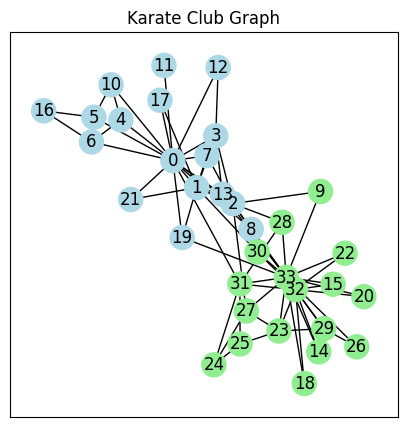

In [ ]:
data = prepare_karate_data()

Now, we're going to create our GNN model (from scratch). We're going to be implementing the Graph Convolutional Network (Kipf & Welling 2017).

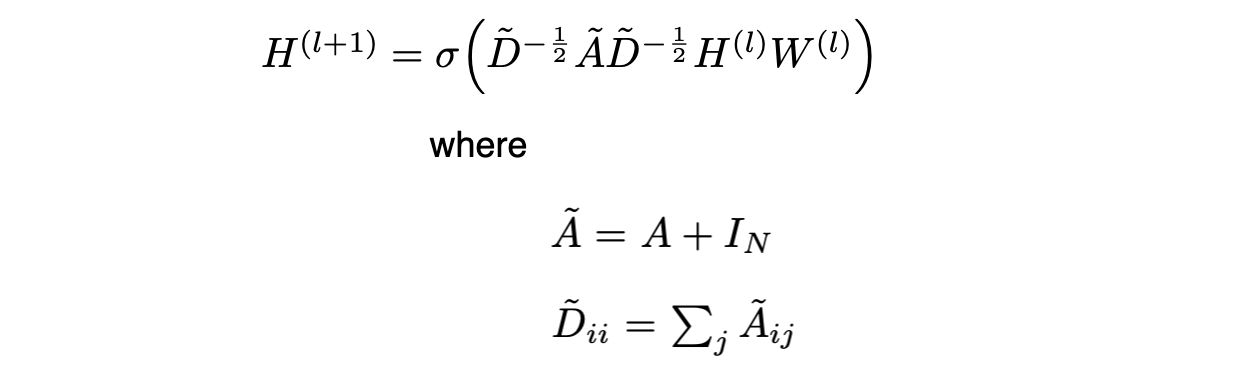

In [ ]:
#############################
# GCN Layer (Following Kipf & Welling, 2017)
#############################
class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        # Learnable weight matrix (W in the paper).
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, edge_index):
        """
        Args:
            x (Tensor): Node features of shape [N, in_channels].
            edge_index (LongTensor): Graph connectivity with shape [2, E].

        Returns:
            Tensor: Updated node features of shape [N, out_channels].
        """
        num_nodes = x.size(0)

        # ---- 1. Add Self-Loops ----
        self_loops = torch.arange(num_nodes, device=x.device).unsqueeze(0).repeat(2, 1)
        edge_index = torch.cat([edge_index, self_loops], dim=1)

        # ---- 2. Compute the Degree for Each Node ----
        row, col = edge_index
        deg = torch.zeros(num_nodes, device=x.device)
        deg.scatter_add_(0, row, torch.ones_like(row, dtype=x.dtype))

        # ---- 3. Compute the Normalization Factor ----
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # ---- 4. Linear Transformation ----
        x = torch.mm(x, self.weight)

        # ---- 5. Neighborhood Aggregation ----
        out = torch.zeros_like(x)
        # Breaking down the aggregation into multiple steps for clarity:
        source_features = x[row]          # Features from source nodes.
        norm_factor = norm.unsqueeze(1)   # Reshape norm to [E, 1].
        scaled_messages = norm_factor * source_features  # Scale features.
        out = out.index_add(0, col, scaled_messages)      # Sum scaled messages into target nodes.

        return out

#############################
# Node Classification Model using GCNLayer
#############################
class NodeClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_layers=2):
        super(NodeClassifier, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        if num_layers == 1:
            self.convs.append(GCNLayer(in_channels, num_classes))
        else:
            self.convs.append(GCNLayer(in_channels, hidden_channels))
            for _ in range(num_layers - 2):
                self.convs.append(GCNLayer(hidden_channels, hidden_channels))
            self.convs.append(GCNLayer(hidden_channels, num_classes))

    def forward(self, data, return_hidden=False):
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:
                x = F.relu(x)
        if return_hidden:
            return x
        return x

In [ ]:
def train_node_classifier(data, model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if (epoch+1) % 1 == 0:
            pred = out.argmax(dim=1)
            correct = int((pred == data.y).sum())
            acc = correct / data.num_nodes
            print(f"Epoch {epoch+1:3d}: Loss {loss.item():.4f}, Training Acc {acc:.4f}")

def evaluate_node_classifier(data, model, mask='test'):
    model.eval()
    with torch.no_grad():
        out = model(data)
        if mask == 'train':
            pred = out[data.train_mask].argmax(dim=1)
            correct = (pred == data.y[data.train_mask]).sum().item()
            return correct / data.train_mask.sum().item()
        else:
            pred = out[data.test_mask].argmax(dim=1)
            correct = (pred == data.y[data.test_mask]).sum().item()
            return correct / data.test_mask.sum().item()

In [ ]:
# Run node classification example
model = NodeClassifier(in_channels=data.num_node_features, hidden_channels=16, num_classes=2, num_layers=2)
train_node_classifier(data, model)

Epoch   1: Loss 0.7092, Training Acc 0.5000
Epoch   2: Loss 0.6936, Training Acc 0.5000
Epoch   3: Loss 0.6788, Training Acc 0.5000
Epoch   4: Loss 0.6645, Training Acc 0.5000
Epoch   5: Loss 0.6506, Training Acc 0.5294
Epoch   6: Loss 0.6371, Training Acc 0.6471
Epoch   7: Loss 0.6235, Training Acc 0.7353
Epoch   8: Loss 0.6102, Training Acc 0.8529
Epoch   9: Loss 0.5966, Training Acc 0.8824
Epoch  10: Loss 0.5826, Training Acc 0.8824


In [ ]:
test_acc = evaluate_node_classifier(data, model, mask='test')
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8571


What about edge prediction? What if we want to classify edges?

The above architecture and many other architectures do not inherently generate/learn embeddings for edges but we can still perform edge prediction with them.

### Oversmoothing Example

Sometimes in other architectures (CNNs in particular), more layers generally mean better performance.

However, in GNNs, this may not be the case due to oversmoothing.

In [ ]:
#############################
# Utility Function to Compute Average Pairwise Cosine Similarity
#############################
def compute_average_cosine_similarity(embeddings):
    """
    Computes the average pairwise cosine similarity between node embeddings.
    A high average similarity indicates that node representations are very alike
    (i.e., oversmoothing has occurred).

    Args:
        embeddings (Tensor): Node embeddings of shape [num_nodes, features].

    Returns:
        float: Average pairwise cosine similarity (excluding self-similarity).
    """
    # Normalize embeddings.
    norm_embeddings = F.normalize(embeddings, p=2, dim=1)
    # Compute cosine similarity matrix.
    sim_matrix = torch.matmul(norm_embeddings, norm_embeddings.t())
    num_nodes = sim_matrix.size(0)
    # Exclude self-similarity by masking the diagonal.
    mask = torch.eye(num_nodes, device=sim_matrix.device).bool()
    avg_sim = sim_matrix[~mask].mean().item()
    return avg_sim

In [ ]:
for num_layers in [2, 4, 8, 16]:
    print(f"\nTraining model with {num_layers} GCN layers:")
    model = NodeClassifier(in_channels=data.num_node_features,
                            hidden_channels=16,
                            num_classes=2,
                            num_layers=num_layers)
    train_node_classifier(data, model, epochs=10, lr=0.01)

    # After training, obtain the final node embeddings.
    model.eval()
    with torch.no_grad():
        embeddings = model(data, return_hidden=True)
    avg_sim = compute_average_cosine_similarity(embeddings)
    print(f"Average pairwise cosine similarity of final embeddings: {avg_sim:.4f}")
    # A higher similarity (closer to 1.0) is indicative of oversmoothing.


Training model with 2 GCN layers:
Epoch   1: Loss 0.6858, Training Acc 0.6471
Epoch   2: Loss 0.6777, Training Acc 0.7353
Epoch   3: Loss 0.6695, Training Acc 0.7941
Epoch   4: Loss 0.6610, Training Acc 0.9118
Epoch   5: Loss 0.6524, Training Acc 0.9412
Epoch   6: Loss 0.6437, Training Acc 0.9706
Epoch   7: Loss 0.6344, Training Acc 0.9706
Epoch   8: Loss 0.6243, Training Acc 0.9706
Epoch   9: Loss 0.6135, Training Acc 1.0000
Epoch  10: Loss 0.6017, Training Acc 1.0000
Average pairwise cosine similarity of final embeddings: 0.1953

Training model with 4 GCN layers:
Epoch   1: Loss 0.7028, Training Acc 0.5000
Epoch   2: Loss 0.6957, Training Acc 0.5000
Epoch   3: Loss 0.6915, Training Acc 0.5000
Epoch   4: Loss 0.6887, Training Acc 0.5000
Epoch   5: Loss 0.6854, Training Acc 0.5000
Epoch   6: Loss 0.6809, Training Acc 0.7647
Epoch   7: Loss 0.6752, Training Acc 0.8529
Epoch   8: Loss 0.6685, Training Acc 0.8824
Epoch   9: Loss 0.6602, Training Acc 0.8824
Epoch  10: Loss 0.6494, Trainin

As GNNs get deeper, they may begin to generate the same embeddings for all nodes since their k-hop neighbours are the same.

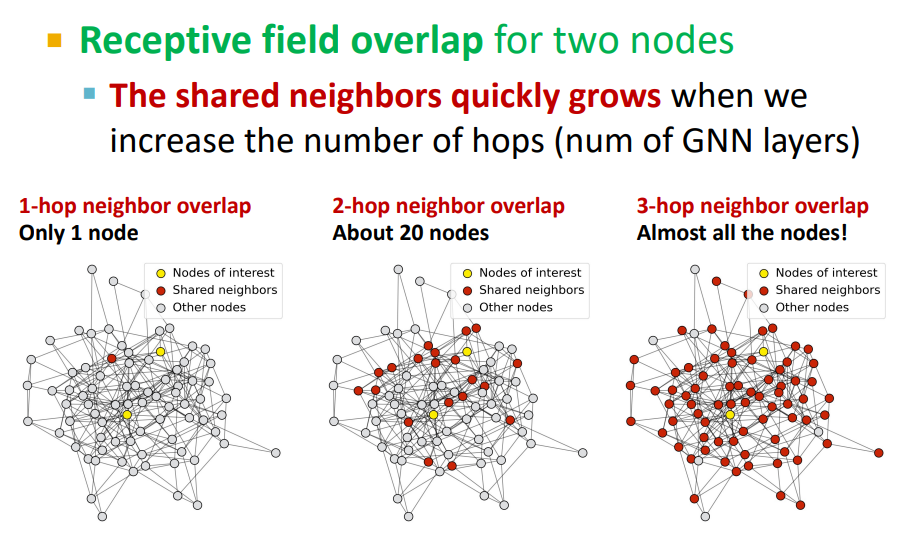



---


### Graph Classification

Now, we're going to be going over a graph prediction (quite similar to node prediction) problem on the MUTAG dataset.

The MUTAG dataset is a widely used benchmark in graph classification.
It consists of 188 graphs, each representing a chemical compound.
The label of each graph indicates whether the compound is mutagenic on
Salmonella typhimurium (1 for mutagenic, 0 for non-mutagenic).

Each node in a graph represents an atom and comes with a feature vector
that represents what type of atom it is (via one one encoding).

MUTAG Dataset Info:
  Number of graphs: 188
  Number of classes: 2
  Number of node features: 7

Sample Graph Data:
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

Sample Node Features:
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


Processing...
Done!


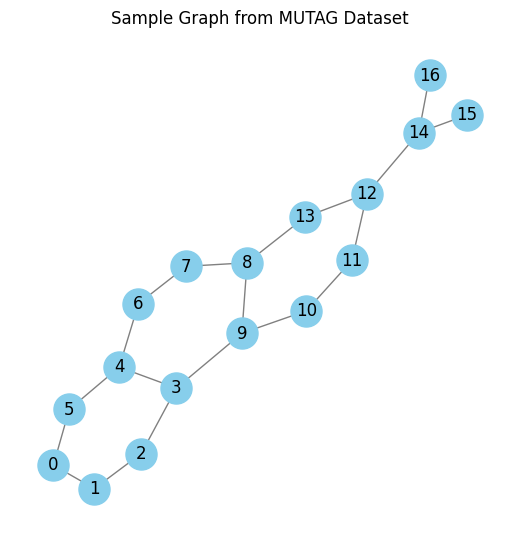

In [ ]:
from torch_geometric.datasets import TUDataset

###############################################
# MUTAG Dataset
###############################################

# Load the dataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print("MUTAG Dataset Info:")
print(f"  Number of graphs: {len(dataset)}")
print(f"  Number of classes: {dataset.num_classes}")
print(f"  Number of node features: {dataset.num_node_features}")

# Inspect a sample graph
sample_data = dataset[0]
print("\nSample Graph Data:")
print(sample_data)
print("\nSample Node Features:")
print(sample_data.x)

# Visualize the connectivity of the sample graph using NetworkX.
G = nx.Graph()
edges = sample_data.edge_index.t().tolist()
G.add_edges_from(edges)

plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Sample Graph from MUTAG Dataset")
plt.show()



---
We already have a model that generates embeddings for each node in the graph.

To obtain a graph-level representation, we can use graph pooling, which aggregates these node embeddings into a single, fixed-size vector. This is can be achieved by operations such as summing, averaging, or taking the maximum of the node features, thereby transforming variable-size node-level information into a consistent graph-level embedding.

In this tutorial, we use the straightforward approach of global mean pooling.

In [ ]:
###############################################
# Graph Classification Model
###############################################
class GraphClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_layers=2):
        """
        A graph classification model using custom GCN layers.
        """
        super(GraphClassifier, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        if num_layers == 1:
            self.convs.append(GCNLayer(in_channels, num_classes))
        else:
            # First layer: input -> hidden.
            self.convs.append(GCNLayer(in_channels, hidden_channels))
            # Middle layers (if any): hidden -> hidden.
            for _ in range(num_layers - 2):
                self.convs.append(GCNLayer(hidden_channels, hidden_channels))
            # Final layer: hidden -> num_classes.
            self.convs.append(GCNLayer(hidden_channels, num_classes))

    def forward(self, data):
        """
        Args:
            data: A data object with attributes:
                  - x: Node features (Tensor of shape [N, F]).
                  - edge_index: Edge indices (Tensor of shape [2, E]).
                  - y: Graph label (Tensor with a single value).
        Returns:
            Tensor: Graph-level output (logits) with shape [num_classes].
        """
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:
                x = F.relu(x)
        # Global mean pooling: average node embeddings to obtain a graph-level embedding.
        graph_embedding = x.mean(dim=0)
        return graph_embedding

###############################################
# Training and Evaluation Functions
###############################################
def train(model, dataset, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out.unsqueeze(0), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataset)

def test(model, dataset, device):
    model.eval()
    correct = 0
    for data in dataset:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=0)
        if pred.item() == data.y.item():
            correct += 1
    return correct / len(dataset)

In [ ]:
###############################################
# Prepare Train/Test Split
###############################################
torch.manual_seed(42)
dataset = dataset.shuffle()
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

In [ ]:
###############################################
# Main Training Loop
###############################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphClassifier(in_channels=7, hidden_channels=64, num_classes=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train(model, train_dataset, optimizer, device)
    train_acc = test(model, train_dataset, device)
    test_acc = test(model, test_dataset, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Loss {loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")

Epoch  10: Loss 0.4912, Train Acc 0.7467, Test Acc 0.6579
Epoch  20: Loss 0.4800, Train Acc 0.7533, Test Acc 0.6842
Epoch  30: Loss 0.4756, Train Acc 0.7667, Test Acc 0.6842
Epoch  40: Loss 0.4731, Train Acc 0.7600, Test Acc 0.6842
Epoch  50: Loss 0.4713, Train Acc 0.7667, Test Acc 0.6842
Epoch  60: Loss 0.4696, Train Acc 0.7600, Test Acc 0.6842




---


### Input Features

Input features significantly influence the performance of our model.

In this dataset, the original node features are one-hot encodings that indicate the type of each atom. Now, we will explore what happens when these informative features are removed and replaced by a constant value of 1 for every node.

In [ ]:
# Remove original node features by replacing them with a constant vector [1] for each node.
# Get the list of Data objects.
data_list = [data for data in dataset]
for data in data_list:
    num_nodes = data.num_nodes
    data.x = torch.ones((num_nodes, 1), dtype=torch.float)

# Overwrite the dataset with the modified data_list.
dataset.data, dataset.slices = dataset.collate(data_list)

# Verify on a sample graph.
sample_data = dataset[0]
print("\nAfter Changing to Constant Features:")
print("Sample node features:")
print(sample_data.x)

dataset = dataset.shuffle()
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

In [ ]:
###############################################
# Main Training Loop
###############################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphClassifier(in_channels=1, hidden_channels=64, num_classes=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train(model, train_dataset, optimizer, device)
    train_acc = test(model, train_dataset, device)
    test_acc = test(model, test_dataset, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Loss {loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")


In many real-world applications (e.g., biochemistry) we often lack rich input features for our data which can severely hinder model performance. When explicit node features are absent, we can instead compute structural properties (like node degree, PageRank score, clustering coefficient, etc.) that capture important aspects of the graph's topology.

This is typically done using the NetworkX library; you can refer to its documentation for various available options.

*  [Centrality measures](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)

*  [Clustering measures](https://networkx.org/documentation/stable/reference/algorithms/clustering.html)






In [ ]:
# We will update each graph so that node features become a 2-dimensional vector:
# [node_degree, pagerank]
updated_data_list = []
for data in dataset:
    num_nodes = data.num_nodes
    # Create a NetworkX graph from the data's edge_index.
    G = nx.Graph()
    edges = data.edge_index.t().tolist()  # convert [2, E] to list of edge tuples
    G.add_edges_from(edges)

    # Compute node degree for each node.
    degrees = torch.tensor([G.degree[i] for i in range(num_nodes)], dtype=torch.float).view(num_nodes, 1)

    # Compute PageRank for each node.
    pagerank_dict = nx.pagerank(G)
    pageranks = torch.tensor([pagerank_dict[i] for i in range(num_nodes)], dtype=torch.float).view(num_nodes, 1)

    # Concatenate the features: new feature vector becomes [degree, pagerank]
    data.x = torch.cat([degrees, pageranks], dim=1)

    updated_data_list.append(data)

# Update the dataset with the new data objects containing 3-dimensional features.
dataset.data, dataset.slices = dataset.collate(updated_data_list)

# Verify on a sample graph.
sample_data = dataset[0]
print("\nAfter Adding Structural Features:")
print("Sample node features:")
print(sample_data.x)

dataset = dataset.shuffle()
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

In [ ]:
###############################################
# Main Training Loop
###############################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphClassifier(in_channels=2, hidden_channels=64, num_classes=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train(model, train_dataset, optimizer, device)
    train_acc = test(model, train_dataset, device)
    test_acc = test(model, test_dataset, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Loss {loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")


We can see that incorporating just two structural features can lead to a significant performance boost—even outperforming the model when using the original node features.



---



### Using PyG modules

So far, we've implemented our own GCN and pooling functions, but that's not strictly necessary—PyG provides a wide array of built-in convolutional and pooling layers.

In this next section, we'll use the Residual Gated Graph Convolution layer (Bresson et al., 2017) from PyG. This layer offers advanced message passing capabilities along with residual connections to help train deeper networks. For more options and details on available layers, check out the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html).



In [ ]:
from torch_geometric.nn import global_mean_pool, ResGatedGraphConv

###############################################
# Define the Graph Classification Model using ResGatedGraphConv
###############################################
class GraphClassifierResGated(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_layers=4):
        """
        A graph classification model using PyG's ResGatedGraphConv layers.

        Args:
            in_channels (int): Input feature dimension.
            hidden_channels (int): Hidden layer dimension.
            num_classes (int): Number of output classes.
            num_layers (int): Number of ResGatedGraphConv blocks to stack.
        """
        super(GraphClassifierResGated, self).__init__()

        self.convs = nn.ModuleList()
        # If only one layer is specified, map directly from input to num_classes.
        if num_layers == 1:
            self.convs.append(ResGatedGraphConv(in_channels, num_classes))
        else:
            # First layer: from in_channels to hidden_channels.
            self.convs.append(ResGatedGraphConv(in_channels, hidden_channels))
            # Middle layers: hidden -> hidden.
            for _ in range(num_layers - 2):
                self.convs.append(ResGatedGraphConv(hidden_channels, hidden_channels))
            # Final layer: hidden -> num_classes.
            self.convs.append(ResGatedGraphConv(hidden_channels, num_classes))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        # Global mean pooling aggregates node features into graph-level representations.
        x = global_mean_pool(x, batch)
        return x

# Verify on a sample graph.
sample_data = dataset[0]
print("\nAfter Adding Structural Features:")
print("Sample node features:")
print(sample_data.x)

dataset = dataset.shuffle()
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

In [ ]:
###############################################
# Main Training Loop
###############################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphClassifier(in_channels=2, hidden_channels=64, num_classes=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train(model, train_dataset, optimizer, device)
    train_acc = test(model, train_dataset, device)
    test_acc = test(model, test_dataset, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Loss {loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")

In this tutorial, we implemented the GCN for both node classification and graph classification tasks—the latter achieved using global mean pooling. We also experimented a little bit with different GNN architectures and explored various node feature representations.

In practice, there are many different advanced pooling methods (see: [PyG documentation](https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/nn.html#pooling-layers)). There are also a variety of GNN architectures (see: [PyG documentation](https://www.google.com/url?q=https%3A%2F%2Fpytorch-geometric.readthedocs.io%2Fen%2F2.5.1%2Fmodules%2Fnn.html%23convolutional-layers)) and numerous structural node features that can be computed (see: [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/)).